In [167]:
from utils.ETC import *
from sklearn.utils import resample
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell

import joblib
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb

In [228]:
plt.rc('font', family='GULIM')
warnings.filterwarnings(action='ignore')
InteractiveShell.ast_node_interactivity = "all"

# Load Data

정밀도: 확실히 맞춰라 엄한거 찌르지 말고.
재현율: 틀리든 말든 정답만 맞춰라.

In [252]:
train = pd.read_csv('../Database/test/train_k.csv', index_col=0)
test = pd.read_csv('../Database/test/test_k.csv', index_col=0)
# train = pd.read_csv('../Database/train_optimal.csv', index_col=0)
# test = pd.read_csv('../Database/test_optimal.csv', index_col=0)
test.drop(columns=['is_converted'], inplace=True)
train.drop(columns=['idit_strategic_ver'], inplace=True)
test.drop(columns=['idit_strategic_ver'], inplace=True)

# Sampling

In [253]:
true_data = train[train['is_converted'] == True]
bootstrap_sample = resample(true_data, replace=True, n_samples=1200, random_state=123)
train = pd.concat([train, bootstrap_sample], axis=0)

{False, True}

([<matplotlib.patches.Wedge at 0x22beab3c790>,
 [Text(0.5815118034079504, -0.93372588188249, 'False'),
  Text(-0.5815118252633814, 0.9337258682712238, 'True')],
 [Text(0.3171882564043365, -0.5093050264813581, '90.0%'),
  Text(-0.3171882683254807, 0.5093050190570311, '10.0%')])

(-1.0999999987062474,
 1.0999999769258073,
 -1.0999997596394653,
 1.0999998269051556)

Text(0.5, 1.0, 'Class Distribution')

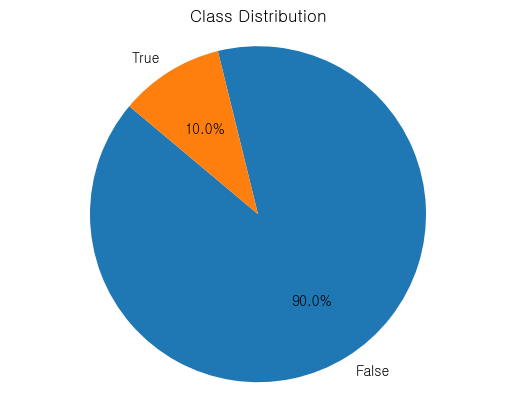

In [254]:
X = train.drop(columns=['is_converted'])
y = train['is_converted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
minority_indexes = np.where(y_train == 1)[0]

class_counts = y_train.value_counts()
set(class_counts.index)
plt.pie(class_counts, labels=class_counts.index, startangle=140, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Class Distribution')
plt.show()

smoteto = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=42)
X_train, y_train = smoteto.fit_resample(X_train, y_train)

In [ ]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

smoteto = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=42)
X_smoteto, y_smoteto = smoteto.fit_resample(X_train, y_train)

In [217]:
smote_data = pd.concat([X_smote, y_smote], axis=1)
smote_data = smote_data[smote_data['is_converted'] == True & (~smote_data.index.isin(minority_indexes))]

adasyn_data = pd.concat([X_adasyn, y_adasyn], axis=1)
adasyn_data = adasyn_data[adasyn_data['is_converted'] == True & (~adasyn_data.index.isin(minority_indexes))]

smoteto_data = pd.concat([X_smoteto, y_smoteto], axis=1)
# smoteto_data = smoteto_data[smoteto_data['is_converted'] == True & (~smoteto_data.index.isin(minority_indexes))]

In [218]:
synthetic_data = pd.concat([smote_data, adasyn_data], axis=0)
synthetic_data = resample(synthetic_data, replace=True, n_samples=40000, random_state=123)

In [219]:
X_syn = synthetic_data.drop(columns=['is_converted'])
y_syn = synthetic_data['is_converted']

X_train = pd.concat([X_train, X_syn], axis=0)
y_train = pd.concat([y_train, y_syn], axis=0)

# Feature Importance Checking by lightGBM

LGBMClassifier(boosting_type='gbrt', colsample_bytree=0.937353322028252,
               device='cpu', early_stopping_rounds=10, eval_metric='F1',
               learning_rate=0.1020007772584772, max_depth=13,
               min_data_in_leaf=52, n_estimators=1000, num_leaves=168,
               objective='binary', subsample=0.4728706071427491, verbose=-1)

오차행렬:
 [[ 1062   125]
 [  174 10739]]

정확도: 0.9753
정밀도: 0.8592
재현율: 0.8947
F1: 0.8766


1187

1236

1775

<Figure size 1000x800 with 0 Axes>

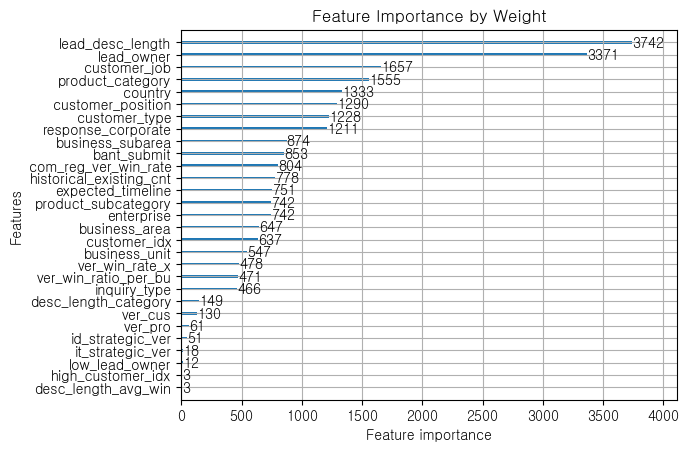

<Figure size 1000x800 with 0 Axes>

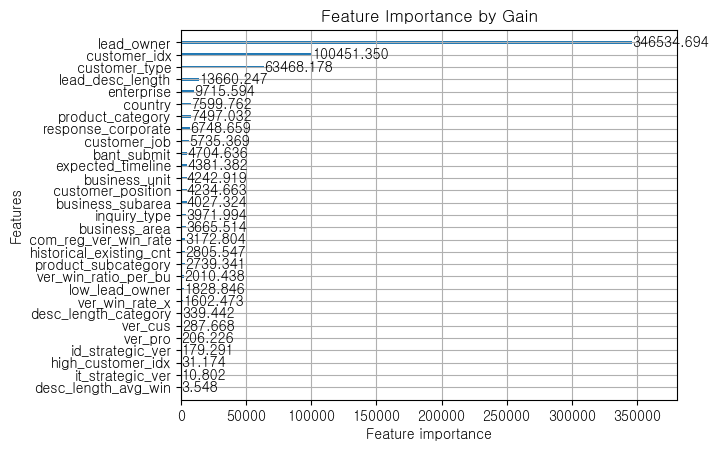

In [255]:
params = {
    'device': 'cpu',
    'boosting_type': 'gbrt',
    'objective': 'binary',
    'eval_metric': 'F1',
    'early_stopping_rounds': 10,

    'learning_rate': 0.1020007772584772,
    'max_depth': 13,
    'num_leaves': 168,
    'min_data_in_leaf': 52,
    'subsample': 0.4728706071427491,
    'colsample_bytree': 0.937353322028252,
}

bst = lgb.LGBMClassifier(**params, n_estimators=1000, verbose=-1)

bst.fit(X_train, y_train, eval_set=[(X_test, y_test)])
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration_)
get_clf_eval(y_test, y_pred)
# threshold = calculate_roc_curve(y_test, y_pred, True)
# y_pred = np.where(y_pred >= threshold, 1, 0)
sum(y_test)
sum(y_pred)

test_pred = bst.predict(test, num_iteration=bst.best_iteration_)
sum(test_pred)

plot_importace_lightGBM(bst)

# Save Submission Data

In [94]:
train = pd.read_csv('../Database/train_optimal.csv', index_col=0)
test = pd.read_csv('../Database/test_optimal.csv', index_col=0)
# test.drop(columns='is_converted', inplace=True)
X = train.drop(columns=['is_converted'])
y = train['is_converted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgb_model = joblib.load('../Files/lgb_model.pkl')
xgb_model = joblib.load('../Files/xgb_model.pkl')
cat_model = joblib.load('../Files/cat_model.pkl')

In [95]:
proba1 = lgb_model.predict_proba(X_test)[:, 1]
proba2 = xgb_model.predict_proba(X_test)[:, 1]
proba3 = cat_model.predict_proba(X_test)[:, 1]
average_proba = (proba1 + +proba2 + proba3) / 3

optimal_threshold1 = calculate_roc_curve(y_test, proba1, False)
lgb_result1 = np.where(proba1 >= optimal_threshold1, 1, 0)
sum(lgb_result1)

optimal_threshold2 = calculate_roc_curve(y_test, proba2, False)
xgb_result1 = np.where(proba2 >= optimal_threshold2, 1, 0)
sum(xgb_result1)

optimal_threshold3 = calculate_roc_curve(y_test, proba3, False)
cat_result1 = np.where(proba3 >= optimal_threshold3, 1, 0)
sum(cat_result1)

optimal_threshold = calculate_roc_curve(y_test, average_proba, False)
soft_voting_result1 = np.where(average_proba >= optimal_threshold2, 1, 0)
sum(soft_voting_result1)

print("lightGBM f1_score:", f1_score(y_test, lgb_result1))
print("XGBoost f1_score:", f1_score(y_test, xgb_result1))
print("CatBoost f1_score:", f1_score(y_test, cat_result1))
print("Soft Voting f1_score:", f1_score(y_test, soft_voting_result1))

get_clf_eval(y_test, soft_voting_result1)

proba1 = lgb_model.predict_proba(test)[:, 1]
proba2 = xgb_model.predict_proba(test)[:, 1]
proba3 = cat_model.predict_proba(test)[:, 1]

average_proba = (proba1 + proba2 + proba3) / 3
result1 = np.where(proba1 >= optimal_threshold1, 1, 0)
sum(result1)
result2 = np.where(proba2 >= optimal_threshold2, 1, 0)
sum(result2)
result3 = np.where(proba3 >= optimal_threshold3, 1, 0)
sum(result3)
soft_voting_result = np.where(average_proba >= optimal_threshold, 1, 0)
sum(soft_voting_result)

Optimal Threshold: 0.12121212121212122


1388

Optimal Threshold: 0.21212121212121213


1371

Optimal Threshold: 0.030303030303030304


1386

Optimal Threshold: 0.09090909090909091


1258

lightGBM f1_score: 0.7787610619469026
XGBoost f1_score: 0.7801358234295416
CatBoost f1_score: 0.7811050189793337
Soft Voting f1_score: 0.8078466339723585
오차행렬:
 [[  906    79]
 [  352 10523]]

정확도: 0.9637
정밀도: 0.7202
재현율: 0.9198
F1: 0.8078


1671

1912

1851

2188

In [96]:
proba1 = lgb_model.predict_proba(X_test)
proba2 = xgb_model.predict_proba(X_test)
proba3 = cat_model.predict_proba(X_test)
average_proba = (proba1 + +proba2 + proba3) / 3

lgb_result1 = np.argmax(proba1, axis=1)
xgb_result1 = np.argmax(proba2, axis=1)
cat_result1 = np.argmax(proba3, axis=1)
soft_voting_result1 = np.argmax(average_proba, axis=1)

sum(lgb_result1)
sum(xgb_result1)
sum(cat_result1)
sum(soft_voting_result1)

print("lightGBM f1_score:", f1_score(y_test, lgb_result1))
print("XGBoost f1_score:", f1_score(y_test, xgb_result1))
print("CatBoost f1_score:", f1_score(y_test, cat_result1))
print("Soft Voting f1_score:", f1_score(y_test, soft_voting_result1))

get_clf_eval(y_test, soft_voting_result1)

proba1 = lgb_model.predict_proba(test)
proba2 = xgb_model.predict_proba(test)
proba3 = cat_model.predict_proba(test)
average_proba = (proba1 + proba2 + proba3) / 3
lgb_result1 = np.argmax(proba1, axis=1)
xgb_result1 = np.argmax(proba2, axis=1)
cat_result1 = np.argmax(proba3, axis=1)
soft_voting_result = np.argmax(average_proba, axis=1)

sum(result1)
sum(result2)
sum(result3)
sum(soft_voting_result)

1002

1082

998

1018

lightGBM f1_score: 0.8344237544036236
XGBoost f1_score: 0.8224479922593129
CatBoost f1_score: 0.8381240544629349
Soft Voting f1_score: 0.8397403894158761
오차행렬:
 [[  841   144]
 [  177 10698]]

정확도: 0.9729
정밀도: 0.8261
재현율: 0.8538
F1: 0.8397


1671

1912

1851

1099

In [80]:
answer = pd.read_csv('../Database/submission.csv')
answer['is_converted'] = soft_voting_result
answer.to_csv('../Files/submission.csv')
sum(answer['is_converted'])

1961